In [191]:
import pandas as pd
import matplotlib.pyplot as plt

In [192]:
SOLVER_VERSION = "data-collection-3"

In [193]:
df = pd.read_csv("../log/database.csv")
input_df = pd.read_csv("../log/input.csv")

In [194]:
solver_df = pd.merge(df[df.solver_version == SOLVER_VERSION], input_df, how="left", on="input_file")
solver_df

,input_file,solver_version,score,duration,query_count,n,m,eps,dense
0,tools/in/0000.txt,data-collection-3,0.707107,3.1395,7,15,2,0.01,0.168889
1,tools/in/0001.txt,data-collection-3,6.337479,16.4577,48,13,6,0.04,0.159763
2,tools/in/0002.txt,data-collection-3,4.230085,12.1795,30,13,2,0.07,0.402367
3,tools/in/0003.txt,data-collection-3,2.356660,9.1322,20,19,2,0.08,0.315789
4,tools/in/0004.txt,data-collection-3,25.692689,27.5753,153,16,8,0.14,0.367188
...,...,...,...,...,...,...,...,...,...
995,tools/in/0995.txt,data-collection-3,20.115794,24.2652,113,14,8,0.14,0.346939
996,tools/in/0996.txt,data-collection-3,13.302157,21.2299,83,12,6,0.09,0.375000
997,tools/in/0997.txt,data-collection-3,1.778002,7.0820,15,13,4,0.01,0.497041
998,tools/in/0998.txt,data-collection-3,6.161125,17.2132,54,16,8,0.02,0.289062


In [195]:
solver_df["query_count"] /= (solver_df["n"] ** 2) * 2

In [196]:
num_cols = ["score", "duration", "n", "m", "eps", "dense", "query_count"]
solver_df[num_cols].corr()

,score,duration,n,m,eps,dense,query_count
score,1.000000,0.519691,0.164242,0.408743,0.258484,-0.111438,0.675745
duration,0.519691,1.000000,0.463017,0.772986,0.451417,-0.208415,0.878184
n,0.164242,0.463017,1.000000,0.570359,0.000661,-0.005304,0.149146
m,0.408743,0.772986,0.570359,1.000000,-0.048762,-0.059006,0.597754
eps,0.258484,0.451417,0.000661,-0.048762,1.000000,-0.016663,0.495730
dense,-0.111438,-0.208415,-0.005304,-0.059006,-0.016663,1.000000,-0.231838
query_count,0.675745,0.878184,0.149146,0.597754,0.495730,-0.231838,1.000000


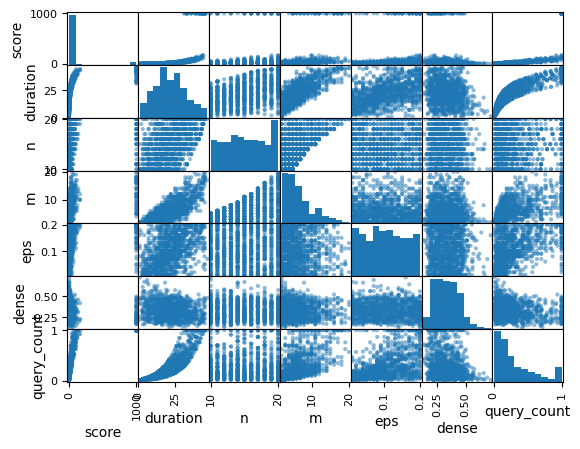

In [197]:
_ = pd.plotting.scatter_matrix(solver_df[num_cols])

In [198]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LinearRegression

df = pd.read_csv("../log/database.csv")
input_df = pd.read_csv("../log/input.csv")
solver_df = pd.merge(df[df.solver_version == SOLVER_VERSION], input_df, how="left", on="input_file")

In [199]:
# solver_df.loc[solver_df.score == 1000.0, "query_count"] *= 1.2

In [200]:
feature_cols = ["n", "m", "eps", "dense"]
alphas = [0.5, 2.0]

data_df = solver_df[num_cols]
data_df.loc[:, ["target"]] = data_df["query_count"]

data_df = data_df.drop(["score", "duration", "query_count"], axis=1)

# 特徴量
for col in feature_cols:
    for alpha in alphas:
        data_df.loc[:, [f"{col}.powf({alpha})"]] = data_df[col] ** alpha

for col1 in feature_cols:
    for alpha1 in alphas:
        for col2 in feature_cols:
            for alpha2 in alphas:
                c1 = f"{col1}.powf({alpha1})"
                c2 = f"{col2}.powf({alpha2})"
                data_df.loc[:, [f"{c1} * {c2}"]] = data_df[c1] * data_df[c2]
                data_df.loc[:, [f"{c1} / {c2}"]] = data_df[c1] / data_df[c2]

x = data_df.drop(["target"], axis=1)
y = data_df["target"]

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)

model = Ridge(alpha=1e-3)
model.fit(train_x, train_y)

# print(model.coef_)
# print(model.intercept_)
print(model.score(train_x, train_y))
print(model.score(test_x, test_y))
expr = " + ".join([f"{c:.5} * {t}" for c, t in zip(model.coef_.flatten(), x.columns)]) + f" + {model.intercept_:.5}"
print(expr)
with open("../log/expr.txt", "w") as f:
    f.write(expr + "\n")

0.9003127472543515
0.8786154010309479
-69.205 * n + -226.14 * m + 100.61 * eps + 481.03 * dense + 29.599 * n.powf(0.5) + 233.29 * n.powf(2.0) + -352.47 * m.powf(0.5) + 180.19 * m.powf(2.0) + -41.214 * eps.powf(0.5) + 109.12 * eps.powf(2.0) + 264.39 * dense.powf(0.5) + 643.24 * dense.powf(2.0) + -69.205 * n.powf(0.5) * n.powf(0.5) + 0.0 * n.powf(0.5) / n.powf(0.5) + -18.427 * n.powf(0.5) * n.powf(2.0) + -27.053 * n.powf(0.5) / n.powf(2.0) + -164.62 * n.powf(0.5) * m.powf(0.5) + 1007.8 * n.powf(0.5) / m.powf(0.5) + -27.159 * n.powf(0.5) * m.powf(2.0) + -696.27 * n.powf(0.5) / m.powf(2.0) + -914.21 * n.powf(0.5) * eps.powf(0.5) + -112.35 * n.powf(0.5) / eps.powf(0.5) + -483.17 * n.powf(0.5) * eps.powf(2.0) + 0.030065 * n.powf(0.5) / eps.powf(2.0) + -209.31 * n.powf(0.5) * dense.powf(0.5) + -174.3 * n.powf(0.5) / dense.powf(0.5) + -147.87 * n.powf(0.5) * dense.powf(2.0) + -11.002 * n.powf(0.5) / dense.powf(2.0) + -18.426 * n.powf(2.0) * n.powf(0.5) + -331.08 * n.powf(2.0) / n.powf(0.5) + 0

/Users/tatsuyaishii/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.21526e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


450 466.55080728450685
340 291.0982703537147
15 36.06942213419143
15 48.73591275340186
800 406.9732058454165
375 366.979087065421
83 18.814205377302187
102 154.0513415228811
375 363.60007065343643
23 27.458695646397246


[-49.12813996629984, 760.1911412629042]

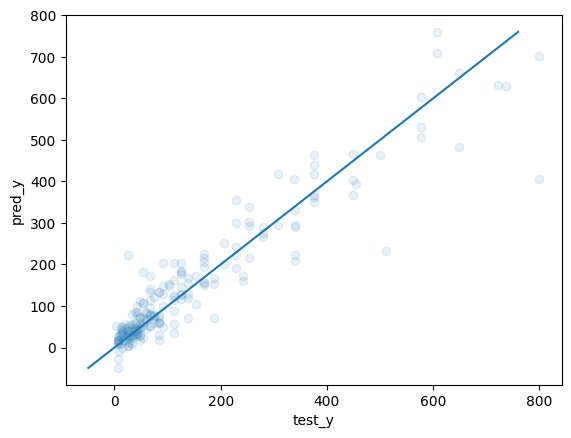

In [201]:
pred_y = model.predict(test_x)
for i in range(10):
    print(test_y.iloc[i], pred_y[i])

plt.scatter(test_y, pred_y, alpha=0.1)
plt.xlabel("test_y")
plt.ylabel("pred_y")
_ = plt.plot([pred_y.min(), pred_y.max()], [pred_y.min(), pred_y.max()])
[pred_y.min(), pred_y.max()]

0.8353038448817681


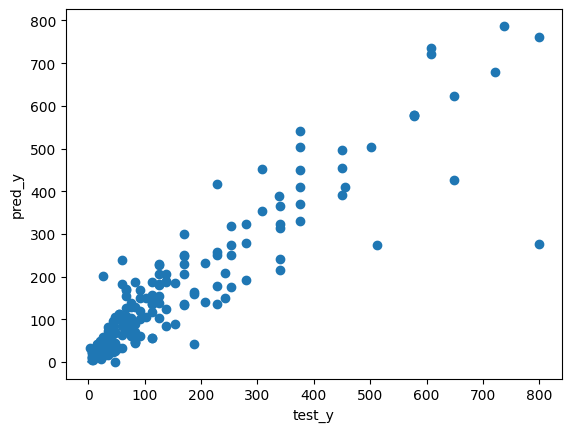

In [202]:
import lightgbm as lgb
from sklearn.metrics import r2_score

params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "random_state": 0,
    "verbose": -1
}

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=0)
train_set = lgb.Dataset(train_x, train_y)
valid_set = lgb.Dataset(valid_x, valid_y, reference=train_set)

model = lgb.train(params=params, train_set=train_set, valid_sets=[valid_set], num_boost_round=1000)

pred_y = model.predict(test_x, num_iteration=model.best_iteration)
print(r2_score(test_y, pred_y))

plt.scatter(test_y, pred_y)
plt.xlabel("test_y")
plt.ylabel("pred_y")
_ = plt.plot([0, 1], [0, 1])